In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=5

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=5


In [2]:
import torch
import jax
import jax.numpy as jnp
import flax
from entmax_jax import sparsemax
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML
from functools import partial
import json
from entmax_jax.activations import sparsemax, entmax15
from sklearn.metrics import roc_auc_score, average_precision_score

from meta_expl.explainers import load_explainer
from meta_expl.models import load_model
from meta_expl.data.mlqe import dataloader
from utils import aggregate_pieces

from evaluate_explanations import evaluate_word_level, evaluate_sentence_level, aggregate_pieces

### plot utils

In [3]:
def detokenize(pieces):
    return ''.join(pieces).replace('▁', ' ').replace('</s>', ' </s>')

def colorize_twoway(words, color_array, label='GOLD', max_width_shown=1800):
    template_pos = '<span class="barcode"; style="color: black; background-color: rgba(0, 255, 0, {}); display:inline-block; font-size:12px;">&nbsp {} &nbsp</span>'
    template_neg = '<span class="barcode"; style="color: black; background-color: rgba(255, 0, 0, {}); display:inline-block; font-size:12px;">&nbsp {} &nbsp</span>'
    colored_string = ''
    f = lambda w: w.replace('<', 'ᐸ').replace('>', 'ᐳ')
    for word, color in zip(words, color_array):
        if color >= 0:
            colored_string += template_pos.format(color, f(word))
        else:
            colored_string += template_neg.format(-color, f(word))
    html_text = '<div style="width:100%">{}:&nbsp;&nbsp; {}</div>'.format(label, colored_string)
    display(HTML(html_text))

def show_explanation(tokens, tags, explanation):
    colorize_twoway(tokens.split(), torch.tensor(tags), label='gold')
    colorize_twoway(tokens.split(), torch.tensor(explanation), label='pred')

def plot_attention_map(words, attn_weights, vmax=1, ax=None):
    df = pd.DataFrame(attn_weights, columns=words, index=words)
    sns.heatmap(df, vmax=vmax, cmap="Greens", square=True, cbar=False, ax=ax)

### data utils

In [4]:
# data utils
def unroll(list_of_lists):
    return [e for ell in list_of_lists for e in ell]

def read_data(lp, split='dev'):
    def tags_to_ints(line):
        return list(map(int, line.strip().replace('OK', '0').replace('BAD', '1').split()))
    data = {
        'original': [line.strip() for line in open('data/mlqepe/{}/{}.src'.format(lp, split), 'r')],
        'translation': [line.strip() for line in open('data/mlqepe/{}/{}.mt'.format(lp, split), 'r')],
        'z_mean': [float(line.strip()) for line in open('data/mlqepe/{}/{}.da'.format(lp, split), 'r')],
        'src_tags': [tags_to_ints(line) for line in open('data/mlqepe/{}/{}.src-tags'.format(lp, split), 'r')],
        'mt_tags': [tags_to_ints(line) for line in open('data/mlqepe/{}/{}.tgt-tags'.format(lp, split), 'r')]
    }
    data['da'] = data['z_mean']
    data = [dict(zip(data.keys(), v)) for v in list(zip(*data.values()))]
    return data

def read_data_all(lps, split='dev'):
    data = {
        'original': [],
        'translation': [],
        'z_mean': [],
        'src_tags': [],
        'mt_tags': [],
    }
    data['da'] = data['z_mean']
    for lp in lps:
        ell = read_data(lp, split)
        for key in data.keys():
            data[key].extend([d[key] for d in ell])
    data = [dict(zip(data.keys(), v)) for v in list(zip(*data.values()))]
    return data

### define args

In [5]:
# arguments
arch = 'xlm-roberta-base'
setup = 'static_teacher'  # "no_teacher", "static_teacher", "learnable_teacher"

seed = 9
max_len = 256
batch_size = 16

sep_token = "</s>" if 'xlm' in arch else "[SEP]"
num_classes = 1
task_type = "regression"
dataloader = partial(dataloader, sep_token=sep_token)

teacher_dir = 'data/mlqe-xlmr-models/teacher_dir'
teacher_expl_dir = 'data/mlqe-xlmr-models/teacher_expl_dir'
student_dir = 'data/mlqe-xlmr-models/student_dir'
student_expl_dir = 'data/mlqe-xlmr-models/student_expl_dir'

In [6]:
# create dummy inputs for model instantiation
input_ids = jnp.ones((batch_size, max_len), jnp.int32)
dummy_inputs = {
    "input_ids": input_ids,
    "attention_mask": jnp.ones_like(input_ids),
    "token_type_ids": jnp.arange(jnp.atleast_2d(input_ids).shape[-1]),
    "position_ids": jnp.ones_like(input_ids),
}
dummy_inputs['input_ids'].shape

(16, 256)

### load tokenizer

In [7]:
from transformers import XLMRobertaTokenizerFast
tokenizer = XLMRobertaTokenizerFast.from_pretrained(arch)
cls_id = tokenizer.cls_token_id
sep_id = tokenizer.sep_token_id
pad_id = tokenizer.pad_token_id
print(tokenizer.sep_token)

</s>


### load models and explainers

In [9]:
teacher, teacher_params, dummy_state = load_model(teacher_dir, dummy_inputs, batch_size, max_len)
teacher_explainer, teacher_explainer_params = load_explainer(teacher_expl_dir, dummy_inputs, state=dummy_state)
student, student_params, dummy_state = load_model(student_dir, dummy_inputs, batch_size, max_len)
student_explainer, student_explainer_params = load_explainer(student_expl_dir, dummy_inputs, state=dummy_state)

### look at the coefficients

In [10]:
sparsemax(teacher_explainer_params['params']['head_coeffs']).reshape(12, 12)

DeviceArray([[0.05825656, 0.05605122, 0.06579615, 0.06052823, 0.05019351,
              0.0858976 , 0.04817941, 0.05621345, 0.01868655, 0.02941416,
              0.04372283, 0.05819663],
             [0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        ],
             [0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        ],
             [0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        ],
             [0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        , 0.        , 0.        , 0.        ,
              0.0433885 , 0.        ],
             [0.        , 0.        , 0.        , 0.        , 0. 

In [11]:
hc = sparsemax(teacher_explainer_params['params']['head_coeffs']).reshape(12, 12)
for a, b in zip(*hc.nonzero()):
    print(a, b, hc[a,b])

0 0 0.058256563
0 1 0.056051224
0 2 0.06579615
0 3 0.06052823
0 4 0.05019351
0 5 0.0858976
0 6 0.048179414
0 7 0.056213446
0 8 0.018686546
0 9 0.029414164
0 10 0.043722827
0 11 0.05819663
4 10 0.043388497
7 8 0.08041232
7 9 0.09685925
8 5 0.0302523
8 7 0.03107029
9 5 0.04859592
10 1 0.028833564
10 3 0.009451524


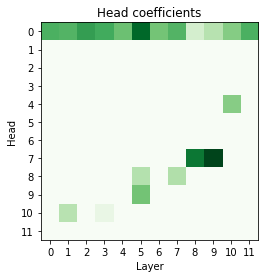

In [13]:
coeffs = np.asarray(hc)
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(coeffs, cmap='Greens')
ax.set_xticks(list(range(12)))
ax.set_yticks(list(range(12)))
ax.set_xlabel('Layer')
ax.set_ylabel('Head')
ax.set_title('Head coefficients')
plt.savefig('head_coeffs_mlqe_horizontal.pdf', dpi=300, bbox_inches='tight')

### Aggregate scores for word pieces in SRC and MT independently

In [41]:
def get_src_and_mt_explanations(tokens, fp_mask, expl, reduction):
    # split data into src and mt (assuming "<s> src </s> mt </s>" format without CLS for mt) 
    src_len = tokens.index(tokenizer.sep_token) + 1
    src_tokens, mt_tokens = tokens[:src_len], tokens[src_len:]
    src_expl, mt_expl = expl[:src_len], expl[src_len:]
    src_fp_mask, mt_fp_mask = fp_mask[:src_len], fp_mask[src_len:]
    # aggregate word pieces scores (use my old good torch function)
    agg_src_expl = aggregate_pieces(torch.tensor(src_expl), torch.tensor(src_fp_mask), reduction)
    agg_mt_expl = aggregate_pieces(torch.tensor(mt_expl), torch.tensor(mt_fp_mask), reduction)
    # remove <s> and </s> from src
    agg_src_expl = agg_src_expl.tolist()[1:-1]
    # remove </s> from mt
    agg_mt_expl = agg_mt_expl.tolist()[:-1]
    return agg_src_expl, agg_mt_expl, src_tokens, mt_tokens

def get_expl(data, idx=0):
    x, y = next(dataloader([data[idx]], tokenizer, batch_size=batch_size, max_len=max_len, shuffle=False))
    y_teacher, teacher_attn = teacher.apply(teacher_params, **x, deterministic=True)
    teacher_expl, _ = teacher_explainer.apply(teacher_explainer_params, x, teacher_attn)
    y_student, student_attn = student.apply(student_params, **x)
    student_expl, _ = student_explainer.apply(student_explainer_params, x, student_attn)
    batch_ids = x['input_ids'].tolist()
    batch_tokens = [tokenizer.convert_ids_to_tokens(ids) for ids in batch_ids]
    batch_masks = [[tk.startswith('▁') for tk in tks] for tks in batch_tokens]
    teacher_attn = np.asarray(jnp.stack(teacher_attn['attentions']).transpose([1, 0, 2, 3, 4]))
    student_attn = np.asarray(jnp.stack(student_attn['attentions']).transpose([1, 0, 2, 3, 4]))
    return {
        'teacher_attn': teacher_attn[0],
        'teacher_expl': teacher_expl.tolist()[0],
        'student_attn': student_attn[0],
        'student_expl': student_expl.tolist()[0],
        'y_teacher': y_teacher.tolist()[0],
        'y_student': y_student.tolist()[0],
        'tokens': batch_tokens[0],
        'masks': batch_masks[0],
    }

In [75]:
idx = 3
lp = 'ro-en'
train_data = read_data(lp, 'train')
valid_data = read_data(lp, 'dev')
test_data = read_data(lp, 'test')
data = valid_data

gold_src_tokens = data[idx]['original']
gold_mt_tokens =  data[idx]['translation']
gold_expls_src = data[idx]['src_tags']
gold_expls_mt = data[idx]['mt_tags']
gold_score = data[idx]['z_mean']

pred = get_expl(data, idx)
pred_score = pred['y_teacher']
pred_tokens = pred['tokens']
pred_masks = pred['masks']
pred_expls = pred['teacher_expl']
pred_attn = pred['teacher_attn']

pred_expls_src, pred_expls_mt, _, _ = get_src_and_mt_explanations(
    pred_tokens, pred_masks, pred_expls, reduction='sum'
)
sum_norm = lambda v: v / v.sum()
min_max_norm = lambda v: (v - v.min()) / (v.max() - v.min())
std_norm = lambda v: (v - v.mean()) / v.std()

print('Gold: ', gold_score)
print('Pred: ', pred_score)
print('SRC:')
print('----')
show_explanation(gold_src_tokens, gold_expls_src, sum_norm(np.array(pred_expls_src)))
print('MT:')
print('----')
show_explanation(gold_mt_tokens, gold_expls_mt, sum_norm(np.array(pred_expls_mt)))

Gold:  -0.474398169618508
Pred:  [-0.11281611770391464]
SRC:
----


MT:
----


<AxesSubplot:>

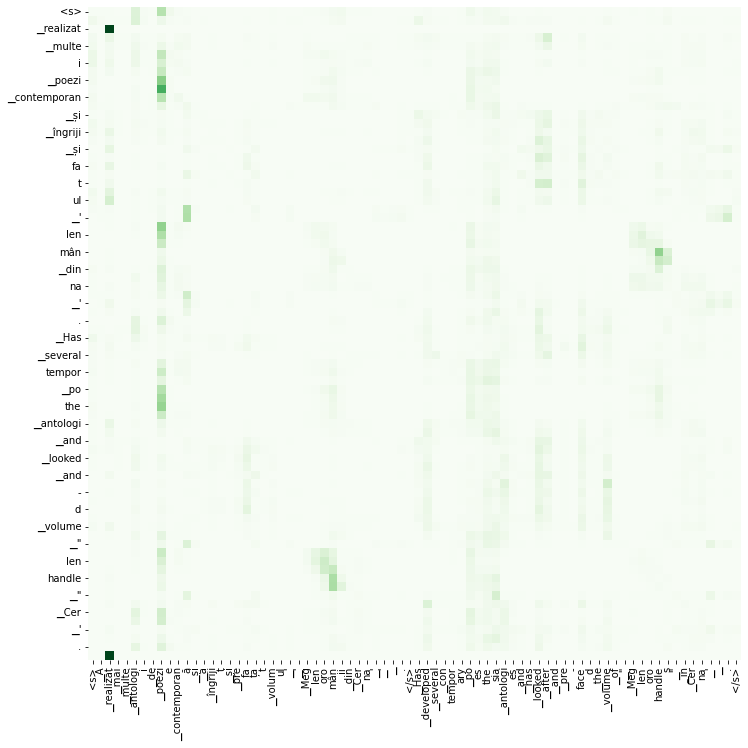

In [65]:
layer_id = 9
head_id = 5
n = pred_tokens.index('<pad>')
tokens = pred_tokens[:n]
attn = flax.nn.softmax(pred_attn[layer_id, head_id, :n, :n], axis=-1)

fig, ax = plt.subplots(figsize=(16, 12))
df = pd.DataFrame(attn, columns=tokens, index=tokens)
sns.heatmap(df, vmax=1, cmap="Greens", square=True, cbar=False, ax=ax)